In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
prop_cycle = plt.rcParams['axes.prop_cycle']
def_colors = prop_cycle.by_key()['color']

In [3]:
plt.rc('font', **{'size': 16})
#plt.rc('text', **{'latex.preamble': [r'\usepackage{mathptmx}',]})
#matplotlib.rcParams.update({
#    'text.usetex': True,
#    'text.latex.preamble': [r'\usepackage{mathptmx}',]})

## Generate data

In [4]:
num_feats = 1000
num_obsvs = 150

#num_feats = 50
#num_obsvs = 100

mod_size = 10

num_causl = 10

In [5]:
# adjacency matrix
W = np.zeros((num_feats, num_feats))
for i in range(num_feats/mod_size):
    W[i*mod_size:(i+1)*mod_size, i*mod_size:(i+1)*mod_size] = np.ones((mod_size, mod_size))
    if not i == (num_feats/mod_size - 1):
        W[(i+1)*mod_size-1, (i+1)*mod_size] = 1
        W[(i+1)*mod_size, (i+1)*mod_size-1] = 1
        
# remove the diagonal
W = W - np.eye(num_feats)

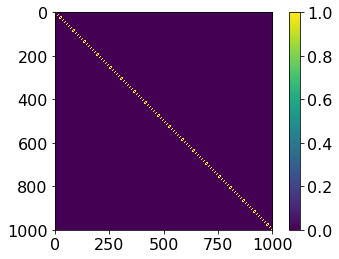

In [6]:
plt.imshow(W)
plt.colorbar()

In [7]:
# SNPs
X = np.random.binomial(1, 0.1, size=(num_obsvs, num_feats))

In [8]:
# Phenotype
w_causl = np.random.normal(loc=0.2, scale=0.05, size=(num_causl))
print w_causl

w = np.zeros((num_feats, ))
w[:num_causl] = w_causl

y = np.dot(X, w) + np.random.normal(loc=0., scale=0.1, size=(num_obsvs, ))

[0.19481259 0.23165967 0.25035667 0.18411663 0.2226847  0.17047022
 0.28477702 0.13743496 0.08748882 0.23936293]


### Shuffle

In [9]:
map_indices_l = range(num_feats)
np.random.shuffle(map_indices_l)
map_indices = dict(zip(range(num_feats), map_indices_l))
map_indices_r = dict(zip(map_indices_l, range(num_feats)))

In [10]:
X = X[:, map_indices_l]

W_new = W[map_indices_l, :]
W_new = W_new[:, map_indices_l]
W = W_new

causl = [map_indices_r[ix] for ix in range(num_causl)]

#plt.imshow(W)

## Train-test split

In [11]:
from sklearn import model_selection

In [12]:
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, test_size=0.3, random_state=17)

## T-test

In [13]:
import statsmodels.api as sm

In [14]:
pvalues = []
for feat_idx in range(num_feats):
    myX = X_train[:, feat_idx]
    myX = sm.add_constant(myX)
    est = sm.regression.linear_model.OLS(y_train, myX)
    est2 = est.fit()
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)
#print pvalues

(0, 1000)

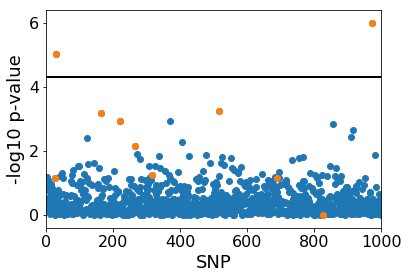

In [15]:
fig = plt.figure(figsize(6, 4))

plt.scatter(range(num_feats), # x = SNP position
            -np.log10(pvalues)) # y = -log10 p-value (the higher the more significant)

# Plot the causal SNPs in red
#plt.scatter(range(num_causl), 
#            -np.log10(pvalues[:num_causl]),
#            color=def_colors[1])
plt.scatter(causl, 
            -np.log10(pvalues[causl]),
            color=def_colors[1])

# significance threshold according to Bonferroni correction
t = -np.log10(0.05/num_feats)
plt.plot([0, num_feats], [t, t], lw=2, c='k')

plt.xlabel("SNP", fontsize=18)
plt.ylabel("-log10 p-value", fontsize=18)
plt.xlim([0, num_feats])

#plt.savefig('manhattan.png', bbox_inches='tight')

### Validation

First of all, no SNP is significant in the study.

What is the significance of the true SNPs on the test set?

In [16]:
pvalues = []
for feat_idx in causl:
    myX = X_test[:, feat_idx]
    myX = sm.add_constant(myX)
    est = sm.regression.linear_model.OLS(y_test, myX)
    est2 = est.fit()
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)
print pvalues

[0.00476219 0.00874662 0.01298761 0.95377124 0.30798421 0.25101582
 0.23150175 0.25821253 0.23621524 0.01327652]


(0, 1000)

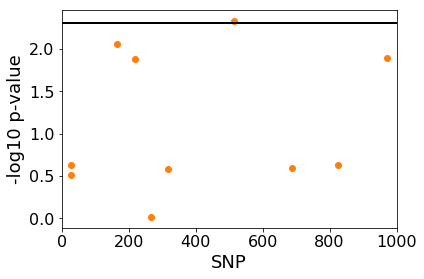

In [17]:
fig = plt.figure(figsize(6, 4))

plt.scatter(causl, 
            -np.log10(pvalues),
            color=def_colors[1])

# significance threshold according to Bonferroni correction
t = -np.log10(0.05/len(causl))
plt.plot([0, num_feats], [t, t], lw=2, c='k')

plt.xlabel("SNP", fontsize=18)
plt.ylabel("-log10 p-value", fontsize=18)
plt.xlim([0, num_feats])

#plt.savefig('manhattan.png', bbox_inches='tight')

## Linear regression 

In [18]:
from sklearn import linear_model

In [19]:
model = linear_model.LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

(0, 1000)

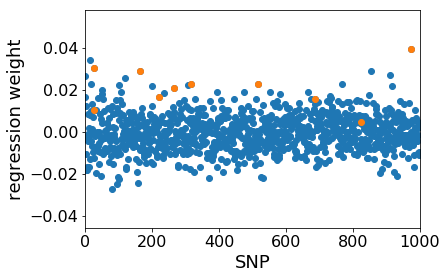

In [20]:
fig = plt.figure(figsize(6, 4))

plt.scatter(range(num_feats), # x = SNP position
            model.coef_) # y = -log10 p-value (the higher the more significant)

# Plot the causal SNPs in red
#plt.scatter(range(num_causl), 
#            -np.log10(pvalues[:num_causl]),
#            color='orange')
plt.scatter(causl, 
            model.coef_[causl],
            color=def_colors[1])

plt.xlabel("SNP", fontsize=18)
plt.ylabel("regression weight", fontsize=18)
plt.xlim([0, num_feats])

#plt.savefig('manhattan.png', bbox_inches='tight')

### Validation

In [21]:
from sklearn import metrics

In [22]:
y_pred = model.predict(X_test)

In [23]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Text(0,0.8,'RMSE = 0.22')

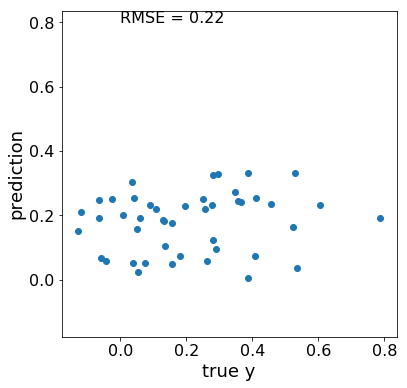

In [24]:
fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred)

plt.xlabel("true y", fontsize=18)
plt.ylabel("prediction", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_test)-0.05, np.max(y_test)+0.05])

plt.text(0, 0.8, 'RMSE = %.2f' % rmse)

#plt.savefig('manhattan.png', bbox_inches='tight')

## Lasso 

In [25]:
model = linear_model.Lasso(fit_intercept=True, alpha=0.01)
model.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

(0, 1000)

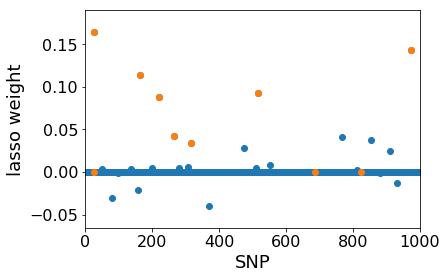

In [26]:
fig = plt.figure(figsize(6, 4))

plt.scatter(range(num_feats), # x = SNP position
            model.coef_) # y = -log10 p-value (the higher the more significant)

# Plot the causal SNPs in red
#plt.scatter(range(num_causl), 
#            -np.log10(pvalues[:num_causl]),
#            color='orange')
plt.scatter(causl, 
            model.coef_[causl],
            color=def_colors[1])

plt.xlabel("SNP", fontsize=18)
plt.ylabel("lasso weight", fontsize=18)
plt.xlim([0, num_feats])

#plt.savefig('manhattan.png', bbox_inches='tight')

### Validation

In [27]:
y_pred = model.predict(X_test)

In [28]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Text(0,0.8,'RMSE = 0.16')

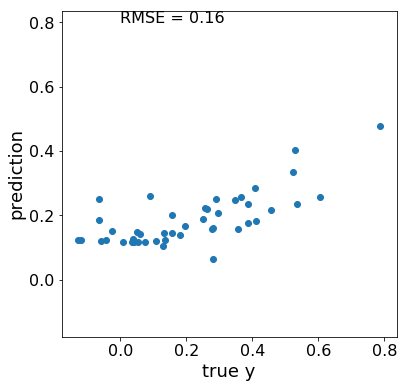

In [29]:
fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred)

plt.xlabel("true y", fontsize=18)
plt.ylabel("prediction", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_test)-0.05, np.max(y_test)+0.05])

plt.text(0, 0.8, 'RMSE = %.2f' % rmse)

#plt.savefig('manhattan.png', bbox_inches='tight')

## Graph Lasso 

### Laplacian

In [30]:
degree = np.sum(W, axis=0)

In [31]:
L = np.diag(degree) - W

In [32]:
#plt.imshow(L)
#plt.colorbar()

In [33]:
evals, evecs = np.linalg.eigh(L)

In [34]:
evals = np.maximum(0, evals)

### Normalized Laplacian

In [35]:
degree = np.atleast_2d(degree) # shape: (1, num_feats)

normalisation = np.dot(np.atleast_2d(degree).T, np.atleast_2d(degree))

L_norm = np.eye(num_feats) - np.array(W, dtype='float')/normalisation

In [36]:
#plt.imshow(L_norm)
#plt.colorbar()

In [37]:
evals_norm, evecs_norm = np.linalg.eigh(L_norm)

In [38]:
evals_norm = np.maximum(0, evals_norm)

### New variables

In [39]:
S = np.dot(evecs, np.diag(evals))

In [40]:
#plt.imshow(S)
#plt.colorbar()

In [41]:
S_norm = np.dot(evecs_norm, np.diag(evals_norm))

In [42]:
#plt.imshow(S_norm)
#plt.colorbar()

In [43]:
#print y.shape
#print np.zeros((num_feats, )).shape
y_new = np.hstack((y_train, np.zeros((num_feats, ))))
#print y_new.shape

In [44]:
l1 = 0.001
l2 = 10.

In [45]:
gamma = l1/(np.sqrt(l2+1))

In [46]:
X_new = 1/(np.sqrt(l2+1)) * np.vstack((X_train, np.sqrt(l2)*S.T))
print X_new.shape

(1105, 1000)


### ncLasso

In [47]:
model = linear_model.Lasso(fit_intercept=True, alpha=gamma)
model.fit(X_new, y_new)

Lasso(alpha=0.00030151134457776364, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

(0, 1000)

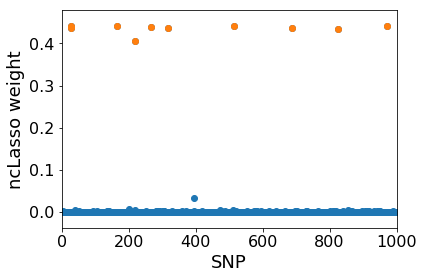

In [48]:
fig = plt.figure(figsize(6, 4))

plt.scatter(range(num_feats), # x = SNP position
            model.coef_) # y = -log10 p-value (the higher the more significant)

# Plot the causal SNPs in red
#plt.scatter(range(num_causl), 
#            -np.log10(pvalues[:num_causl]),
#            color='orange')
plt.scatter(causl, 
            model.coef_[causl],
            color=def_colors[1])

plt.xlabel("SNP", fontsize=18)
plt.ylabel("ncLasso weight", fontsize=18)
plt.xlim([0, num_feats])

#plt.savefig('manhattan.png', bbox_inches='tight')

### Validation

In [49]:
y_test_new = np.hstack((y_test, np.zeros((num_feats, ))))
X_test_new = 1/(np.sqrt(l2+1)) * np.vstack((X_test, np.sqrt(l2)*S.T))

In [50]:
y_pred = model.predict(X_test_new)[:y_test.shape[0]]

In [51]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Text(0,0.8,'RMSE = 0.14')

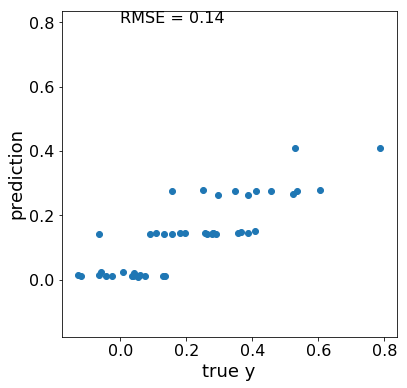

In [52]:
fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred)

plt.xlabel("true y", fontsize=18)
plt.ylabel("prediction", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_test)-0.05, np.max(y_test)+0.05])

plt.text(0, 0.8, 'RMSE = %.2f' % rmse)

#plt.savefig('manhattan.png', bbox_inches='tight')

## SConES / sfan

In [53]:
cd /home/chagaz/repositories/sfan/code/

/home/chagaz/repositories/sfan/code


In [54]:
import tempfile

### Create dimacs file from adjacency matrix

In [55]:
# TODO include in utilities and commit to sfan
def convert_W_to_dimacs(W, dimacs_fname):
    num_edges = np.sum(W)
    print "Considering %d edges" % num_edges
    
    num_features = W.shape[0]
    
    with open(dimacs_fname, 'w') as g:
        #g.write("p max %d %d\n" % ((num_features+2), num_edges))
        g.write("p max %d %d\n" % (num_features, num_edges))
        #g.write("n %d s\n" % (num_features+1))
        #g.write("n %d t\n" % (num_features+2))
        
        for u, v in zip(np.nonzero(W)[0], np.nonzero(W)[1]):
            g.write("a %d %d %d\n" % ((u+1), (v+1), int(W[u, v])))
        g.close()

In [56]:
w_fh, w_fname = tempfile.mkstemp(suffix='network.dimacs')

In [57]:
print w_fname

/tmp/tmpVJlI6Unetwork.dimacs


In [58]:
convert_W_to_dimacs(W, w_fname) 

Considering 9198 edges


### Create node weights file from t-test

In [59]:
# TODO include in utilities and commit to sfan
def compute_node_weights(X, y, node_weights_fname):
    num_features = X.shape[1]
    
    with open(node_weights_fname, 'w') as g:
        for feat_idx in range(num_features):
            myX = X[:, feat_idx]
            myX = sm.add_constant(myX)
            est = sm.regression.linear_model.OLS(y, myX)
            est2 = est.fit()
            g.write("%.3e\n" % np.abs(est2.tvalues[1]))
        g.close()

In [60]:
c_fh, c_fname = tempfile.mkstemp(suffix='scores_0.txt')

In [61]:
print c_fname

/tmp/tmpjWy2QEscores_0.txt


In [62]:
compute_node_weights(X, y, c_fname)

### Initialize sfan
 TODO Replace with calling from the command line ?

In [63]:
from multitask_sfan import Sfan 

In [64]:
model = Sfan(1, [w_fname], [c_fname], 2., 1.)

In [65]:
# Generate super-network in dimacs format
model.create_dimacs()

[18.215378]

### Run sfan 

In [ ]:
model.run_maxflow()

### Get selected SNPS

In [1]:
causl

NameError: name 'causl' is not defined

### Plot selected SNPS

## Clean up

In [ ]:
import os
os.remove(c_fname)
os.remove(w_fname)